<a href="https://colab.research.google.com/github/seemab21/Thesis_Transformer_model/blob/main/MultiClass_Revised_Transformer_Model_Activity_Recognition-KFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup & Dependencies**

In [22]:
import os
import math
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import WeightedRandomSampler

from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Config**

In [23]:
root_dir = '/content/drive/MyDrive/IMU/Annotated_Data'
groups = ['EL', 'PD']
frame_size = 100
feature_cols = [
    'left acceleration X[g]',
    'left acceleration Y[g]',
    'left acceleration Z[g]',
    'right acceleration X[g]',
    'right acceleration Y[g]',
    'right acceleration Z[g]',
    'left angular X[dps]',
    'left angular Y[dps]',
    'left angular Z[dps]',
    'right angular X[dps]',
    'right angular Y[dps]',
    'right angular Z[dps]',
    # Total Force
    "left total force[N]", "right total force[N]",
    # Center of Pressure (CoP)
    "left center of pressure X[%]", "left center of pressure Y[%]",
    "right center of pressure X[%]", "right center of pressure Y[%]"
]
label_map = {'HES': 0, 'HER': 1, 'TOF': 2, 'FOF': 3}

# **Data Loading & Frame Building**

In [24]:
# Function to process a single file
def process_file(filepath):

    # Read the data from the Excel file
    data = pd.read_excel(filepath)

    # Only keep relevant columns + label
    cols_to_check = feature_cols + ['Event- Label level 2- Left Foot']
    data = data[cols_to_check]

    # Fill NaN in features with 0 (not dropping, to avoid data loss)
    data[feature_cols] = data[feature_cols].fillna(0)

    # Map activity labels to numerical values
    data['label'] = data['Event- Label level 2- Left Foot'].map(label_map)

    # Drop rows where label mapping failed (NaN labels)
    data = data.dropna(subset=['label'])
    data['label'] = data['label'].astype(int)

    frames = []
    labels = []

    for i in range(0, len(data) - frame_size + 1, frame_size):
        segment = data.iloc[i:i + frame_size]
        frame = segment[feature_cols].values.flatten()  # shape = [frame_size*12]
        label = np.bincount(segment['label']).argmax()
        frames.append(frame)
        labels.append(label)
    return frames, labels


# Function to load data from multiple groups and preprocess it
def load_all_group_data(root_dir, groups):
    all_frames = []
    all_labels = []
    skipped_files_count = 0
    a_frame = {i: [] for i in range(frame_size * len(feature_cols))}  # Initialize for the flattened frames
    a_frame['label'] = []  # For storing labels

    # Loop through each group folder (EL, PD, etc.)
    for group in groups:
        group_path = os.path.join(root_dir, group)

        # Loop through all Excel files in the group folder
        for file_name in os.listdir(group_path):
            if file_name.endswith('.xlsx'):
                filepath = os.path.join(group_path, file_name)

                try:
                    # Process each file to extract frames and labels
                    frames, labels = process_file(filepath)
                    all_frames.extend(frames)
                    all_labels.extend(labels)

                    # Add frames and labels to the dictionary
                    for frame, label in zip(frames, labels):
                        for i, val in enumerate(frame):
                            a_frame[i].append(val)
                        a_frame['label'].append(label)

                except KeyError as e:
                    # Handle missing columns in the file
                    print(f"File skipped due to missing columns: {filepath}")
                    print(f"Missing columns error: {e}")
                    skipped_files_count += 1
                    continue  # Skip to the next file

    # Convert lists to numpy arrays
    all_frames = np.array(all_frames)
    all_labels = np.array(all_labels, dtype=int)

    print(f"Total files skipped due to missing columns: {skipped_files_count}")

    # Normalize features across ALL data
    scaler = StandardScaler()
    all_frames = scaler.fit_transform(all_frames)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(a_frame)

    return all_frames, all_labels, df, scaler



# Function to compute class weights for imbalanced datasets
# def compute_class_weights(labels):
#    label_counts = np.bincount(labels)
#    total = len(labels)

#    # Class weight formula to handle class imbalance
#   weights = [total / (2 * c) if c > 0 else 0 for c in label_counts]

#    return torch.tensor(weights, dtype=torch.float32)

def compute_class_weights(labels, num_classes):
    classes = np.arange(num_classes)
    w = compute_class_weight(class_weight='balanced',
                             classes=classes,
                             y=labels)
    return torch.tensor(w, dtype=torch.float32)

In [25]:
# Load and preprocess data
frames, labels, df, scaler = load_all_group_data(root_dir, groups)
num_classes = 4
class_weights = compute_class_weights(labels, num_classes)

# Summary of the dataset
print("\n--- Data Summary ---")
print("Frames shape:", frames.shape)        # (num_frames, 300)
print("Labels shape:", labels.shape)        # (num_frames,)
print("Class Weights:", class_weights)

# Display the DataFrame with the frames
print("\n--- DataFrame with frames ---")
print(df.head())
print("Number of features:", len(df.columns))
print("Original DataFrame shape:", df.shape)

print(f"Total number of samples (frames): {frames.shape[0]}")
print(f"Frame size (flattened): {frames.shape[1]}")
print(f"Total number of labels: {labels.shape[0]}")
print(f"Unique labels and counts: {np.unique(labels, return_counts=True)}")

#Check for any remaining NaNs
print(f"\n Any NaN values remaining? {df.isna().any().any()}")

File skipped due to missing columns: /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_1norm2.xlsx
Missing columns error: "['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'right acceleration X[g]', 'right acceleration Y[g]', 'right acceleration Z[g]', 'left angular X[dps]', 'left angular Y[dps]', 'left angular Z[dps]', 'right angular X[dps]', 'right angular Y[dps]', 'right angular Z[dps]', 'left total force[N]', 'right total force[N]', 'left center of pressure X[%]', 'left center of pressure Y[%]', 'right center of pressure X[%]', 'right center of pressure Y[%]'] not in index"
Total files skipped due to missing columns: 1

--- Data Summary ---
Frames shape: (3121, 1800)
Labels shape: (3121,)
Class Weights: tensor([1.3834, 5.1672, 0.5276, 0.8417])

--- DataFrame with frames ---
          0         1         2         3         4         5      6  \
0 -0.258301  0.084961  0.964844  0.000000  0.000000  0.000000  -1.40   
1 -0.286133  0.084473  0.998047 -0.2

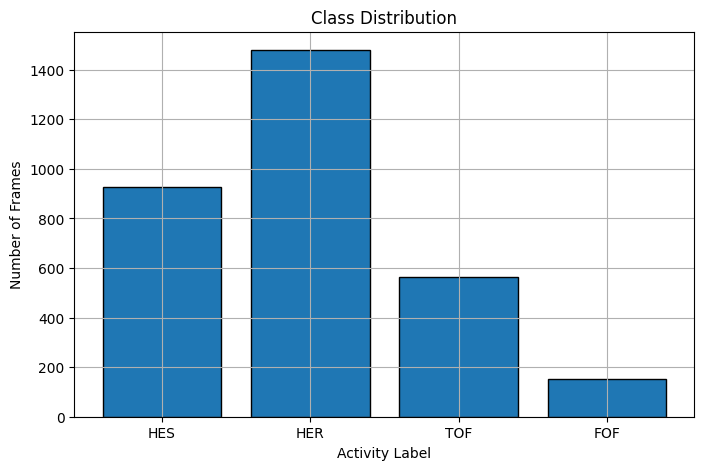

In [26]:
# Mapping back label index to activity name
inv_label_map = {v: k for k, v in label_map.items()}
label_names = [inv_label_map[l] for l in labels]

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.hist(label_names, bins=np.arange(len(label_map)+1)-0.5, edgecolor='black', rwidth=0.8)
plt.xticks(ticks=range(len(label_map)), labels=[inv_label_map[i] for i in range(len(label_map))])
plt.xlabel('Activity Label')
plt.ylabel('Number of Frames')
plt.title('Class Distribution')
plt.grid(True)
plt.show()

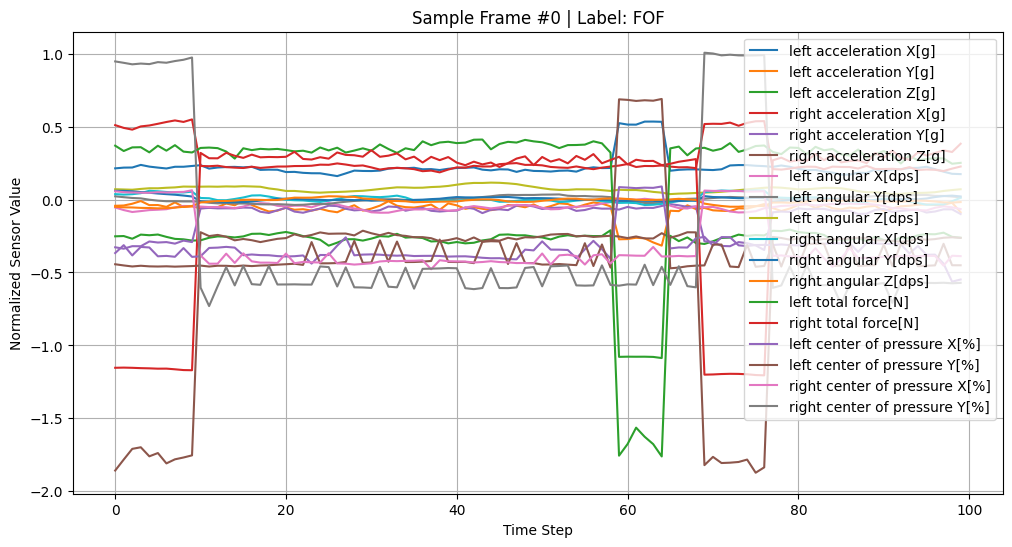

In [27]:
# Choose a sample frame index
sample_index = 0  # Change this to see other samples
sample_frame = frames[sample_index].reshape(frame_size, len(feature_cols))

# Plot each sensor signal in the sample frame
plt.figure(figsize=(12, 6))
for i, col in enumerate(feature_cols):
    plt.plot(range(frame_size), sample_frame[:, i], label=col)

plt.xlabel('Time Step')
plt.ylabel('Normalized Sensor Value')
plt.title(f'Sample Frame #{sample_index} | Label: {inv_label_map[labels[sample_index]]}')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# **Dataset & DataLoader**

In [28]:
from torch.utils.data import WeightedRandomSampler

In [29]:
class IMUDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x, dtype=torch.float32).reshape(-1, 100, 18)
        self.Y = torch.tensor(y, dtype=torch.long).squeeze()

    def __len__(self):
      return len(self.Y)
    def __getitem__(self, idx):
      return self.X[idx], self.Y[idx]

def prepare_dataloaders(x, y, batch_size=32):
    x_train, x_val, y_train, y_val = train_test_split(
        x, y, test_size=0.2, stratify=y, random_state=42
    )

    # Compute class weights from training data
    class_weights = compute_class_weights(y_train, num_classes=4)

    train_loader = DataLoader(IMUDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(IMUDataset(x_val, y_val), batch_size=batch_size, shuffle=False)

    return {'train': train_loader, 'val': val_loader}, class_weights



# **Transformer Model**

In [30]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.4, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, drop_prob=0.3):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model, ffn_hidden)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        # Multi-head self-attention with residual and norm
        _x = x
        x = self.attn(x)
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        # Feed-forward network with residual and norm
        _x = x
        x = self.ffn(x)
        x = self.dropout2(x)
        x = self.norm2(x + _x)

        return x


class Encoder(nn.Module):
    def __init__(self, d_model, n_head, ffn_hidden, n_layers, drop_prob=0.3):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_head, ffn_hidden, drop_prob=drop_prob)
            for _ in range(n_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


###### Classification head missing


In [31]:
class ClassificationHead(nn.Module):
    def __init__(self,d_model, seq_len , n_classes: int = 2):

      super().__init__()
      self.norm = nn.LayerNorm(d_model)
      self.seq = nn.Sequential( nn.Flatten() , nn.Linear(d_model * seq_len , 512),
                               nn.ReLU(),nn.Linear(512, 256),
                               nn.ReLU(),nn.Linear(256, 128),
                                nn.ReLU(),nn.Linear(128, n_classes)
                                )

    def forward(self,x):
      x = self.norm(x)
      x = self.seq(x)
      return x

In [32]:
class TransformerModel(nn.Module):
    def __init__(self, d_model=128, n_head=4, n_layers=4, seq_len=100, hidden=128, num_classes=4, drop_prob=0.4):
        super().__init__()

        # Input projection layer
        self.input_proj = nn.Linear(18, d_model)

        # Positional encoding layer
        self.pos_enc = PositionalEncoding(d_model)

        # Encoder: Adding dropout to each EncoderLayer
        self.encoder = nn.Sequential(*[
            EncoderLayer(d_model, n_head, hidden, drop_prob) for _ in range(n_layers)
        ])

        self.classifier = ClassificationHead(
            d_model=d_model, seq_len=seq_len, n_classes=num_classes
        )

    def forward(self, x):
        # Project input to d_model
        x = self.input_proj(x)

        # Apply positional encoding
        x = self.pos_enc(x)

        # Pass through the encoder layers
        x = self.encoder(x)

        # Pass through the classifier
        return self.classifier(x)


class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        # Compute scaled dot-product attention
        d_k = q.size(-1)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
        attn = self.softmax(scores)

        return torch.matmul(attn, v), attn



class LayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()

        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))

        self.eps = 1e-6


    def forward(self, x):
        # Normalize across the last dimension
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim, drop_prob=0.3):
        super().__init__()

        self.ffn = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(hidden_dim, d_model)
        )

    def forward(self, x):
        return self.ffn(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()

        self.n_head = n_head
        self.attn = ScaleDotProductAttention()

        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, C = x.shape

        qkv = self.qkv_proj(x).reshape(B, T, self.n_head, -1).permute(2, 0, 1, 3)
        q, k, v = torch.chunk(qkv, 3, dim=-1)

        out, _ = self.attn(q, k, v)
        out = out.permute(1, 2, 0, 3).reshape(B, T, C)

        return self.out_proj(out)

# **Training & Evaluation**

In [33]:
def calc_loss(outputs, targets, class_weights, metrics):
    loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
    loss = loss_fn(outputs, targets)

    metrics['loss'].append(loss.item())
    _, preds = torch.max(outputs, 1)
    metrics['correct'] += (preds == targets).sum().item()
    metrics['total'] += targets.size(0)

    return loss



def train_model(model, dataloaders, optimizer, weights, epochs, patience):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train': [], 'val': []}
    epochs_no_improve = 0
    stop_training = False

    # Initialize the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            metrics = {'loss': [], 'correct': 0, 'total': 0}

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    out = model(inputs)
                    loss = calc_loss(out, labels, weights, metrics)
                    if phase == 'train':
                      loss.backward();
                      optimizer.step()

            epoch_loss = np.mean(metrics['loss'])
            epoch_acc = 100 * metrics['correct'] / metrics['total']
            history[phase].append((epoch_loss, epoch_acc))

            # Save model if it improves on validation loss
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(" Best model updated!")
                else:
                    epochs_no_improve += 1

                # Step the scheduler with the validation loss after each epoch
                if scheduler:
                     scheduler.step(epoch_loss)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs!")
                stop_training = True
                break

        if stop_training:
            break


    model.load_state_dict(best_model_wts)
    return model, history

def plot_metrics(history):
    epochs = range(1, len(history['train']) + 1)
    train_loss, train_acc = zip(*history['train'])
    val_loss, val_acc = zip(*history['val'])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, val_loss, label='Val')
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train')
    plt.plot(epochs, val_acc, label='Val')
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.show()

def evaluate_model(model, dataloader, save_path=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute performance metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\nFinal Validation Metrics:")
    print(f"Accuracy : {acc * 100:.2f}%")
    print(f"Precision: {prec * 100:.2f}%")
    print(f"Recall   : {rec * 100:.2f}%")
    print(f"F1 Score : {f1 * 100:.2f}%")


    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to: {save_path}")
    plt.show()

    print("\nDetailed classification report:")
    print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

In [34]:
# Hyperparameters
num_classes = 4
learning_rate = 1e-4
batch_size = 16
epochs = 100
patience = 10

In [35]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# **Run Everything**

File skipped due to missing columns: /content/drive/MyDrive/IMU/Annotated_Data/PD/pd004_1norm2.xlsx
Missing columns error: "['left acceleration X[g]', 'left acceleration Y[g]', 'left acceleration Z[g]', 'right acceleration X[g]', 'right acceleration Y[g]', 'right acceleration Z[g]', 'left angular X[dps]', 'left angular Y[dps]', 'left angular Z[dps]', 'right angular X[dps]', 'right angular Y[dps]', 'right angular Z[dps]', 'left total force[N]', 'right total force[N]', 'left center of pressure X[%]', 'left center of pressure Y[%]', 'right center of pressure X[%]', 'right center of pressure Y[%]'] not in index"
Total files skipped due to missing columns: 1

===== Fold 1/5 =====

Epoch 1/100
------------------------------
Train Loss: 1.1602 | Accuracy: 56.21%
 Best model updated!
Val Loss: 0.9668 | Accuracy: 59.04%

Epoch 2/100
------------------------------
Train Loss: 0.9698 | Accuracy: 62.66%
Val Loss: 0.9857 | Accuracy: 62.24%

Epoch 3/100
------------------------------
Train Loss: 0.9

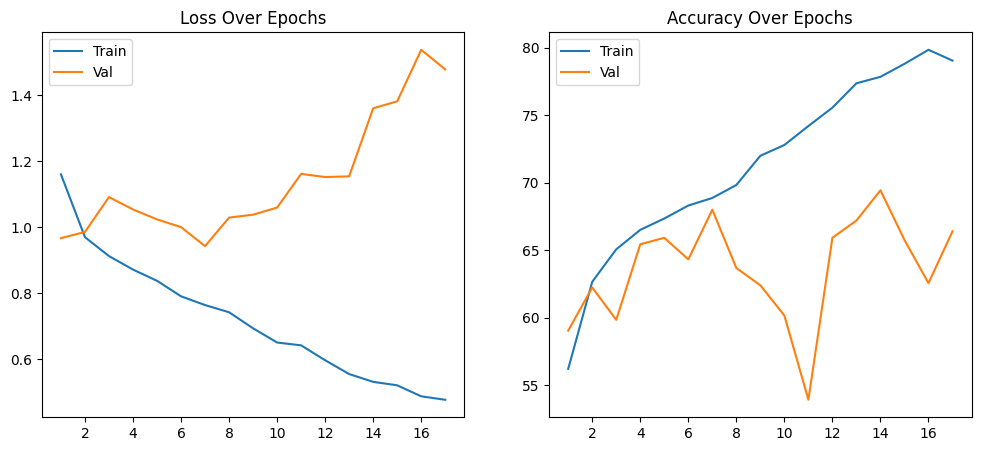


Results for Fold 1:

Final Validation Metrics:
Accuracy : 68.00%
Precision: 70.91%
Recall   : 68.00%
F1 Score : 69.07%


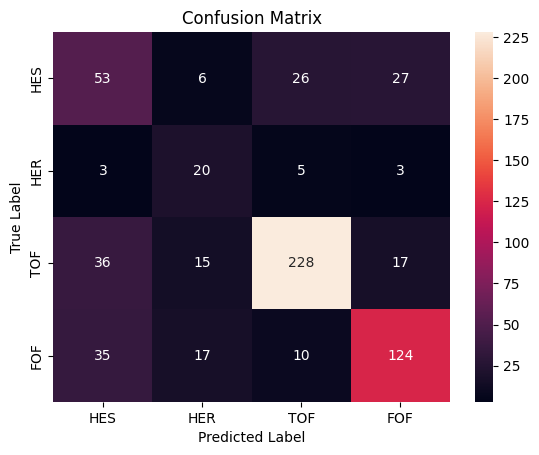


Detailed classification report:
              precision    recall  f1-score   support

         HES       0.42      0.47      0.44       112
         HER       0.34      0.65      0.45        31
         TOF       0.85      0.77      0.81       296
         FOF       0.73      0.67      0.69       186

    accuracy                           0.68       625
   macro avg       0.58      0.64      0.60       625
weighted avg       0.71      0.68      0.69       625


===== Fold 2/5 =====

Epoch 1/100
------------------------------
Train Loss: 1.1537 | Accuracy: 56.43%
 Best model updated!
Val Loss: 1.0779 | Accuracy: 61.70%

Epoch 2/100
------------------------------
Train Loss: 0.9565 | Accuracy: 63.44%
 Best model updated!
Val Loss: 1.0342 | Accuracy: 60.10%

Epoch 3/100
------------------------------
Train Loss: 0.8761 | Accuracy: 64.40%
Val Loss: 1.0993 | Accuracy: 63.78%

Epoch 4/100
------------------------------
Train Loss: 0.8436 | Accuracy: 67.24%
Val Loss: 1.0724 | Accuracy: 62.

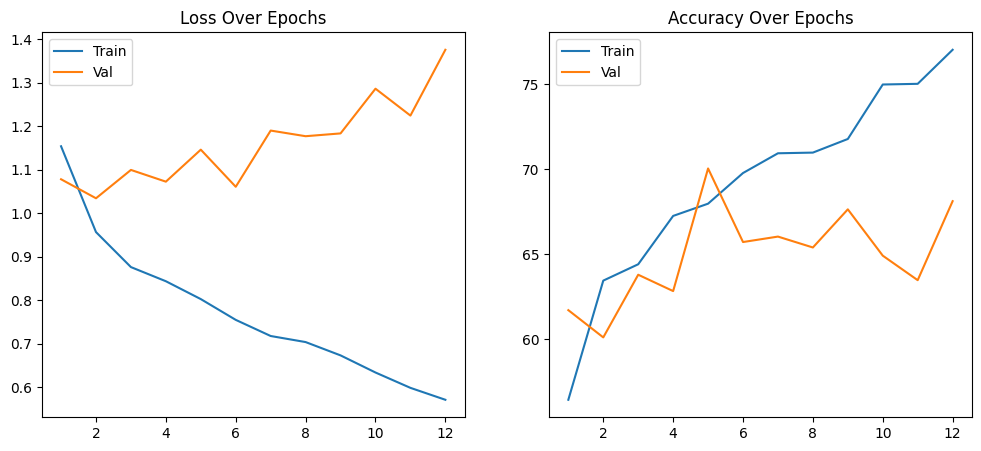


Results for Fold 2:

Final Validation Metrics:
Accuracy : 60.10%
Precision: 65.36%
Recall   : 60.10%
F1 Score : 61.13%


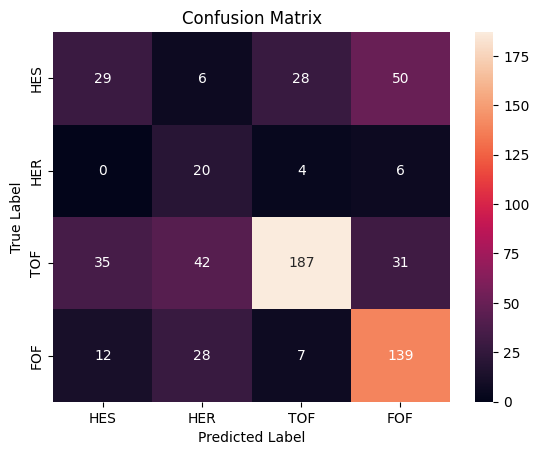


Detailed classification report:
              precision    recall  f1-score   support

         HES       0.38      0.26      0.31       113
         HER       0.21      0.67      0.32        30
         TOF       0.83      0.63      0.72       295
         FOF       0.62      0.75      0.67       186

    accuracy                           0.60       624
   macro avg       0.51      0.58      0.50       624
weighted avg       0.65      0.60      0.61       624


===== Fold 3/5 =====

Epoch 1/100
------------------------------
Train Loss: 1.1892 | Accuracy: 56.23%
 Best model updated!
Val Loss: 1.0027 | Accuracy: 66.51%

Epoch 2/100
------------------------------
Train Loss: 0.9904 | Accuracy: 60.71%
Val Loss: 1.0770 | Accuracy: 68.27%

Epoch 3/100
------------------------------
Train Loss: 0.9099 | Accuracy: 64.32%
 Best model updated!
Val Loss: 0.9985 | Accuracy: 62.66%

Epoch 4/100
------------------------------
Train Loss: 0.8516 | Accuracy: 66.00%
 Best model updated!
Val Loss: 0

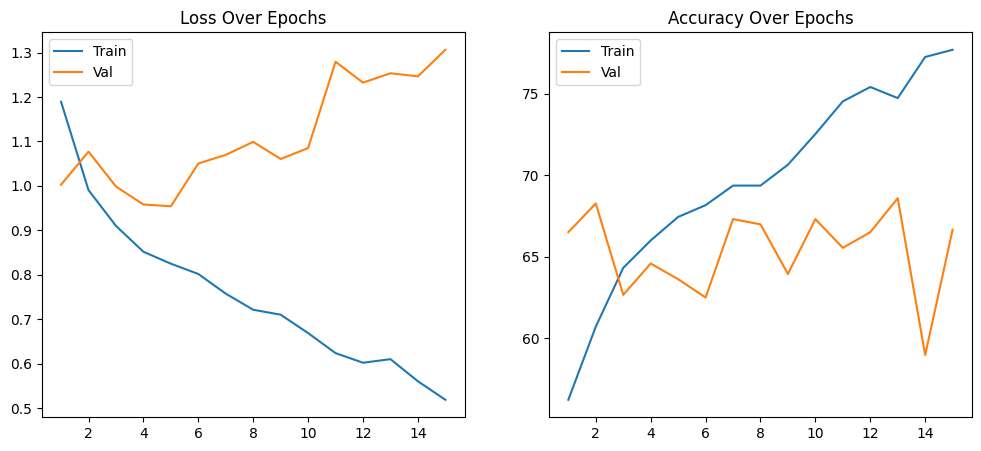


Results for Fold 3:

Final Validation Metrics:
Accuracy : 63.62%
Precision: 68.75%
Recall   : 63.62%
F1 Score : 65.30%


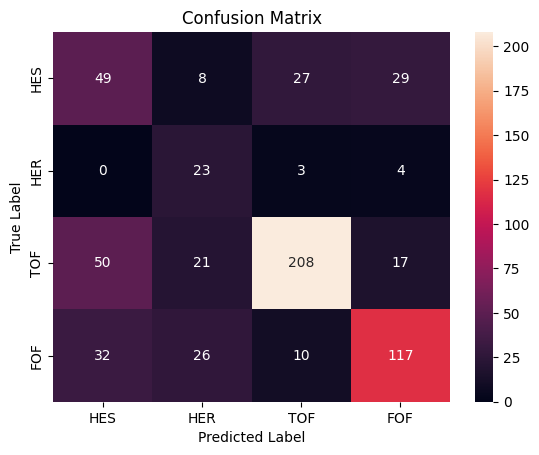


Detailed classification report:
              precision    recall  f1-score   support

         HES       0.37      0.43      0.40       113
         HER       0.29      0.77      0.43        30
         TOF       0.84      0.70      0.76       296
         FOF       0.70      0.63      0.66       185

    accuracy                           0.64       624
   macro avg       0.55      0.63      0.56       624
weighted avg       0.69      0.64      0.65       624


===== Fold 4/5 =====

Epoch 1/100
------------------------------
Train Loss: 1.1534 | Accuracy: 50.26%
 Best model updated!
Val Loss: 1.0270 | Accuracy: 65.71%

Epoch 2/100
------------------------------
Train Loss: 0.9624 | Accuracy: 61.15%
 Best model updated!
Val Loss: 0.9516 | Accuracy: 62.34%

Epoch 3/100
------------------------------
Train Loss: 0.9195 | Accuracy: 64.00%
Val Loss: 1.0686 | Accuracy: 68.75%

Epoch 4/100
------------------------------
Train Loss: 0.8602 | Accuracy: 65.76%
 Best model updated!
Val Loss: 0

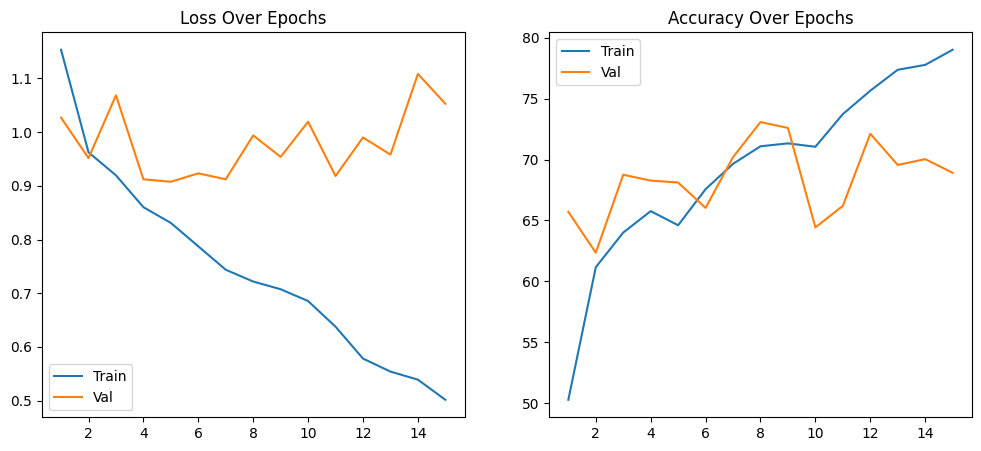


Results for Fold 4:

Final Validation Metrics:
Accuracy : 68.11%
Precision: 71.82%
Recall   : 68.11%
F1 Score : 69.39%


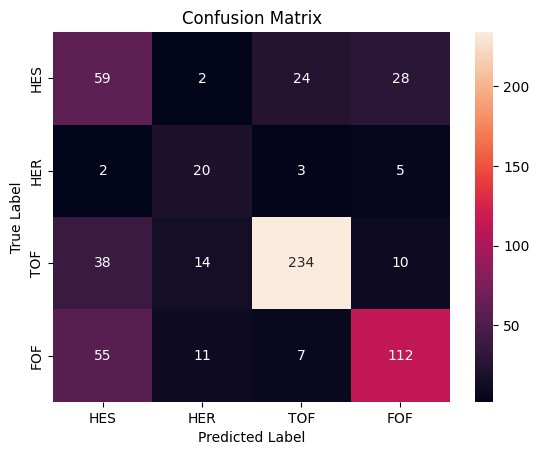


Detailed classification report:
              precision    recall  f1-score   support

         HES       0.38      0.52      0.44       113
         HER       0.43      0.67      0.52        30
         TOF       0.87      0.79      0.83       296
         FOF       0.72      0.61      0.66       185

    accuracy                           0.68       624
   macro avg       0.60      0.65      0.61       624
weighted avg       0.72      0.68      0.69       624


===== Fold 5/5 =====

Epoch 1/100
------------------------------
Train Loss: 1.1650 | Accuracy: 56.99%
 Best model updated!
Val Loss: 1.0410 | Accuracy: 49.84%

Epoch 2/100
------------------------------
Train Loss: 0.9730 | Accuracy: 63.28%
 Best model updated!
Val Loss: 0.9671 | Accuracy: 60.58%

Epoch 3/100
------------------------------
Train Loss: 0.9404 | Accuracy: 64.28%
Val Loss: 1.0023 | Accuracy: 62.02%

Epoch 4/100
------------------------------
Train Loss: 0.8510 | Accuracy: 67.60%
Val Loss: 1.0629 | Accuracy: 61.

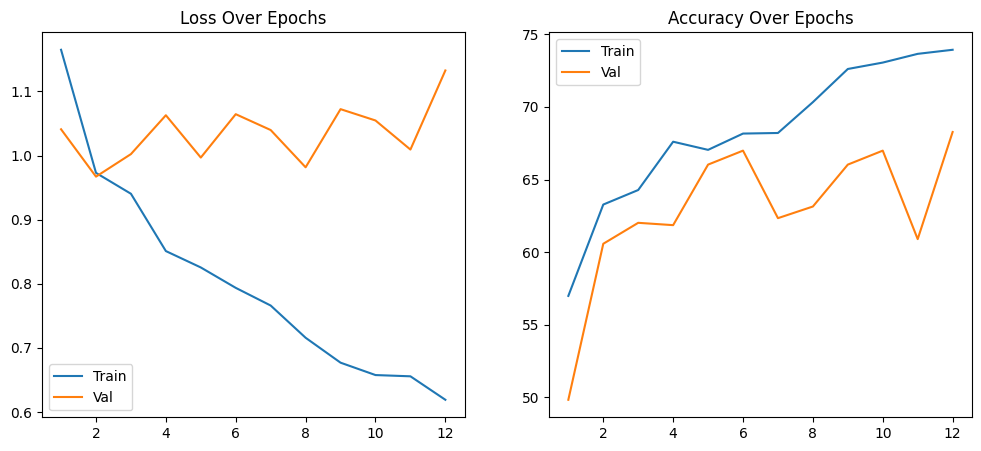


Results for Fold 5:

Final Validation Metrics:
Accuracy : 60.58%
Precision: 67.83%
Recall   : 60.58%
F1 Score : 62.61%


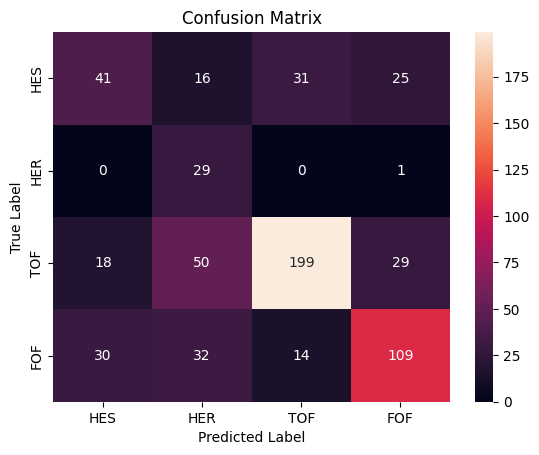


Detailed classification report:
              precision    recall  f1-score   support

         HES       0.46      0.36      0.41       113
         HER       0.23      0.97      0.37        30
         TOF       0.82      0.67      0.74       296
         FOF       0.66      0.59      0.62       185

    accuracy                           0.61       624
   macro avg       0.54      0.65      0.53       624
weighted avg       0.68      0.61      0.63       624


===== 5-Fold Cross-Validation Results =====
Accuracy: 64.08% (+/- 3.46%)
Precision: 68.94%
Recall: 64.08%
F1 Score: 65.50%


In [36]:
frames, labels, df, scaler = load_all_group_data(root_dir, groups)

k_folds = 5  # Or change to 3 or 10 as you wish
all_metrics = []

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(frames, labels)):
    print(f"\n===== Fold {fold+1}/{k_folds} =====")

    x_train, x_val = frames[train_idx], frames[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    # Compute class weights from train split only
    class_weights = compute_class_weights(y_train, num_classes=4)

    dataloaders = {
        'train': DataLoader(IMUDataset(x_train, y_train), batch_size=batch_size, shuffle=True),
        'val': DataLoader(IMUDataset(x_val, y_val), batch_size=batch_size, shuffle=False)
    }

    model = TransformerModel(seq_len=100, num_classes=4).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    trained_model, history = train_model(model, dataloaders, optimizer, class_weights, epochs, patience)
    plot_metrics(history)

    print(f"\nResults for Fold {fold+1}:")
    fold_metrics = evaluate_model(trained_model, dataloaders['val'])  # Must return dict
    all_metrics.append(fold_metrics)

# --- After loop, aggregate results ---
all_acc = [m['accuracy'] for m in all_metrics]
all_prec = [m['precision'] for m in all_metrics]
all_rec = [m['recall'] for m in all_metrics]
all_f1 = [m['f1'] for m in all_metrics]

print(f"\n===== {k_folds}-Fold Cross-Validation Results =====")
print(f"Accuracy: {np.mean(all_acc)*100:.2f}% (+/- {np.std(all_acc)*100:.2f}%)")
print(f"Precision: {np.mean(all_prec)*100:.2f}%")
print(f"Recall: {np.mean(all_rec)*100:.2f}%")
print(f"F1 Score: {np.mean(all_f1)*100:.2f}%")

# Save model
torch.save(trained_model.state_dict(), f"{root_dir}/transformer_model_activity_recognition.pth")